In [1]:
%pylab inline

import os
import pandas as pd
import pickle
pj = os.path.join
import json

import seaborn as sns
sns.set(style="ticks",font_scale=1.5,font='Helvetica')
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))


Populating the interactive namespace from numpy and matplotlib


In [2]:
INPUT_DIR = "/home/floris/DB.Montreal/ArcTrace_Omega/201807_Simon"

In [3]:
files = os.listdir(INPUT_DIR)
prefixes = []
suffixes = ["_parameters.json","_captured.pickle27","_trials.txt"]
for f in files:
    for s in suffixes:
        if f.endswith(s):
            prefixes.append(f[:-len(s)])
prefixes=list(set(prefixes))
prefixes.sort()

In [4]:
# Let's take a look at how many trials are in each file ---
for p in prefixes:
    f = pd.read_csv(pj(INPUT_DIR,p+"_trials.txt"),sep=' ')
    print(p,f.shape[0])

Ibrahim_arc_27_07.15h08m44 2
Ibrahim_arc_27_07.15h09m46 2
Ibrahim_arc_27_07.15h10m16 2
Ibrahim_arc_27_07.15h11m15 50
Ibrahim_arc_27_07.15h17m09 50
Ibrahim_arc_27_07.15h22m51 50
Ibrahim_arc_27_07.15h30m05 50
Julie_arc_25_07.16h21m08 2
Julie_arc_25_07.16h22m48 50
Julie_arc_25_07.16h29m38 50
Julie_arc_25_07.16h36m09 50
Julie_arc_25_07.16h43m09 50
Pierrick_arc_24_07.16h16m05 50
Pierrick_arc_24_07.16h22m36 50
Pierrick_arc_24_07.16h28m29 50
Pierrick_arc_24_07.16h35m53 50
marika_arc_26_07.14h50m35 2
marika_arc_26_07.14h51m55 50
marika_arc_26_07.14h58m00 50
marika_arc_26_07.15h04m23 50
marika_arc_26_07.15h10m00 50


Now from the options above, please select your input files, in the right order too.

In [5]:
#loadfiles = "Pierrick_arc_24_07.16h16m05 Pierrick_arc_24_07.16h22m36 Pierrick_arc_24_07.16h28m29 Pierrick_arc_24_07.16h35m53".split()

In [6]:
#loadfiles = "Julie_arc_25_07.16h22m48 Julie_arc_25_07.16h29m38 Julie_arc_25_07.16h36m09 Julie_arc_25_07.16h43m09".split()

In [7]:
#loadfiles = "marika_arc_26_07.14h51m55 marika_arc_26_07.14h58m00  marika_arc_26_07.15h04m23 marika_arc_26_07.15h10m00 ".split()

In [8]:
loadfiles = "Ibrahim_arc_27_07.15h11m15 Ibrahim_arc_27_07.15h17m09 Ibrahim_arc_27_07.15h22m51 Ibrahim_arc_27_07.15h30m05".split()

In [9]:
alltrials = []
alltrajectories = {}
timestamps = []

cumul_trial = 0
for blocki,f in enumerate(loadfiles):
    tab = pd.read_csv(pj(INPUT_DIR,f+"_trials.txt"),sep=' ')
    tab["block"]=blocki+1 # the index of the block
    
    tab["cumul.trial"]=cumul_trial+tab["trial"]
    cumul_trial=max(tab["cumul.trial"])
    
    alltrials.append(tab)
    
    trial_to_cumul = dict(zip(tab["trial"],tab["cumul.trial"])) # which trial maps to which cumulative trial
    
    trajectories = pickle.load(open(pj(INPUT_DIR,f+"_captured.pickle27"),'rb'))
    
    # Now let's read the trajectories
    for traj in trajectories:
        tr = trial_to_cumul[traj["trial"]]
        thistraj = traj["trajectory"][1:] ### NOTE! Chopping off first data point because of glitch in the script

        # Convert trajectory to cm for ease of interpretation
        x,y,z=zip(*thistraj)
        thistraj = zip(100*array(x),100*array(y),100*array(z))
        
        alltrajectories[tr]=list(thistraj)
        timestamps.append({"cumul.trial":tr,"timestamp":traj["capture.t"]})
    
alltrials = pd.merge(pd.concat(alltrials),pd.DataFrame(timestamps))
alltrials["direction"]=['leftward' if tx<0 else 'rightward' for tx in alltrials["target.x"]]

# Also grab a parameter file while we are at it
params = json.load(open(pj(INPUT_DIR,f+'_parameters.json')))
# Convert m to cm
for quant in ["ARC_BASE_X","ARC_BASE_Y","ARC_RADIUS_1","ARC_RADIUS_2","RIGHT_ARC_ORIGIN","LEFT_ARC_ORIGIN","TARGET_RADIUS"]:
    params[quant]=100*array(params[quant])

In [10]:
alltrials.head()

,participant,experiment,trial,rotation,target.x,target.y,t.go,t.movestart,t.target.enter,t.trial.end,timing,timing.numeric,duration,block,cumul.trial,timestamp,direction
0,Ibrahim,arc,1,0.0,0.01,0.0,4.404355,6.349893,NaN,8.051729,incomplete.trial,99,NaN,1,1,1.532719e+09,rightward
1,Ibrahim,arc,2,0.0,-0.01,0.0,11.557458,11.572544,NaN,13.275476,incomplete.trial,99,NaN,1,2,1.532719e+09,leftward
2,Ibrahim,arc,3,0.0,0.01,0.0,16.780189,18.857388,NaN,20.561042,incomplete.trial,99,NaN,1,3,1.532719e+09,rightward
3,Ibrahim,arc,4,0.0,-0.01,0.0,24.063849,24.802668,NaN,26.507687,incomplete.trial,99,NaN,1,4,1.532719e+09,leftward
4,Ibrahim,arc,5,0.0,0.01,0.0,30.014534,31.281774,NaN,32.986053,incomplete.trial,99,NaN,1,5,1.532719e+09,rightward


In [11]:
blocks = list(set(alltrials["block"]))
print(blocks)

[1, 2, 3, 4]


In [12]:
# The prefix for figures
SUBJECT = alltrials.iloc[0]["participant"]
FIGDIR = 'figs/%s__'%SUBJECT
print(FIGDIR)

figs/Ibrahim__


### For exporting to R?

In [13]:
export = []
for trial in alltrajectories.keys():
    
    tmp = alltrajectories[trial]
    tmp = pd.DataFrame(tmp)
    tmp.columns = ['x', 'y','z']
    tmp["trial"]=trial
    tmp["subject"]=SUBJECT

    export.append(tmp)

export = pd.concat(export)
#export.to_csv('export.csv')
export.head()

,x,y,z,trial,subject
0,0.018223,-0.989171,-0.016425,1,Ibrahim
1,0.018223,-0.989171,-0.016425,1,Ibrahim
2,0.017910,-0.989162,-0.015781,1,Ibrahim
3,0.017910,-0.989162,-0.015781,1,Ibrahim
4,0.017910,-0.989162,-0.015781,1,Ibrahim


## How many trials were too slow (aborted)?

In [14]:
for bl,data in alltrials.groupby('block'):
    n_incomplete = sum(data["timing"]=="incomplete.trial")
    perc = 100*n_incomplete/data.shape[0]
    print("Block %i   #incomplete = %i (%.2f %%)"%(bl,n_incomplete,perc))

Block 1   #incomplete = 15 (30.00 %)
Block 2   #incomplete = 5 (10.00 %)
Block 3   #incomplete = 5 (10.00 %)
Block 4   #incomplete = 4 (8.00 %)


In [15]:
# Overall
n_incomplete = sum(alltrials["timing"]=="incomplete.trial")
perc = 100*n_incomplete/alltrials.shape[0]
print("Overall   #incomplete = %i (%.2f %%)"%(n_incomplete,perc))

Overall   #incomplete = 29 (14.50 %)


### Remove the trajectories corresponding to these aborted trials


In [16]:
for i,row in alltrials.iterrows():
    if row["timing"]=="incomplete.trial":
        tr = row["cumul.trial"]
        alltrajectories[tr]=[]

## Taking a look at individual trials

In [17]:
def draw_arc(ax):
    """ 
    Draw a reference arc in a given plot
    """
    col   = 'black'
    alpha =.8
    lw    = 2

    circangs = linspace(0,2*pi,100)
    
    def arc(center,radius,angs):
        cx,cy=center
        ax.plot((cx+radius*cos(angs)),
                (cy+radius*sin(angs)),color=col,alpha=alpha,lw=lw)
        # What that factor 100 is doing in there? Converting m to cm.

    arc(params["RIGHT_ARC_ORIGIN"],params["TARGET_RADIUS"],circangs)
    arc(params["LEFT_ARC_ORIGIN"] ,params["TARGET_RADIUS"],circangs)    
    
    arc((params["ARC_BASE_X"]-params["ARC_RADIUS_1"],params["ARC_BASE_Y"]),params["ARC_RADIUS_1"],linspace(0,   pi,100))
    arc((params["ARC_BASE_X"]+params["ARC_RADIUS_2"],params["ARC_BASE_Y"]),params["ARC_RADIUS_2"],linspace(pi,2*pi,100))
    ax.set_aspect('equal')

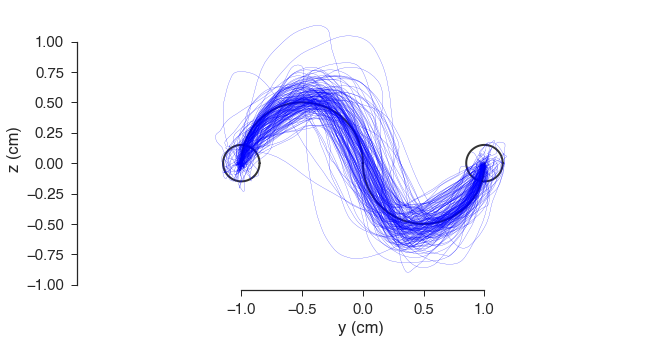

In [18]:
f,ax = subplots(1,1,figsize=(10,5))
draw_arc(ax)
for i,row in alltrials.iterrows():  
    tr = row["cumul.trial"]
    traj = alltrajectories[tr]
    if len(traj):
        x,y,z=zip(*traj)
        plot(y[:],z[:],'-',lw=.2,color='blue')

ax.set_aspect('equal', 'datalim')
xlabel("y (cm)")
ylabel("z (cm)")
sns.despine(offset=5,trim=True)

### Chop it up by block

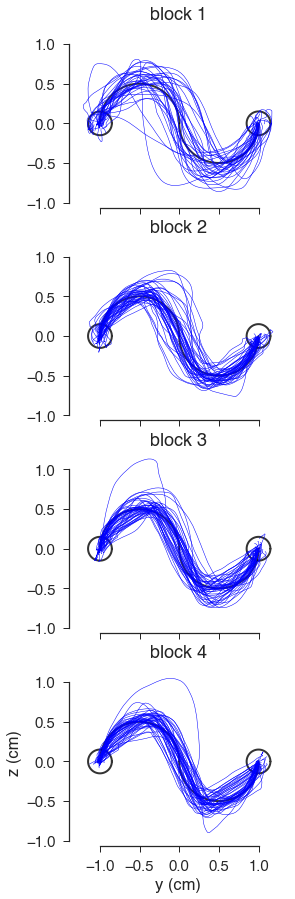

In [19]:
blocks = list(set(alltrials["block"]))

f,axs = subplots(len(blocks),1,figsize=(10,15),sharex=True,sharey=True)
for i,bl in enumerate(blocks):
    axs[i].set_aspect('equal')
    axs[i].set_title("block %i"%bl)
    draw_arc(axs[i])

for i,row in alltrials.iterrows():  
    tr = row["cumul.trial"]
    bl = row["block"]
    ax = axs[blocks.index(bl)]
    traj = alltrajectories[tr]
    if len(traj):
        x,y,z=zip(*traj)
        ax.plot(y[:],z[:],'-',lw=.5,color='blue')
    
xlabel("y (cm)")
ylabel("z (cm)")
sns.despine(offset=5,trim=True)

### Chop it up by block and direction

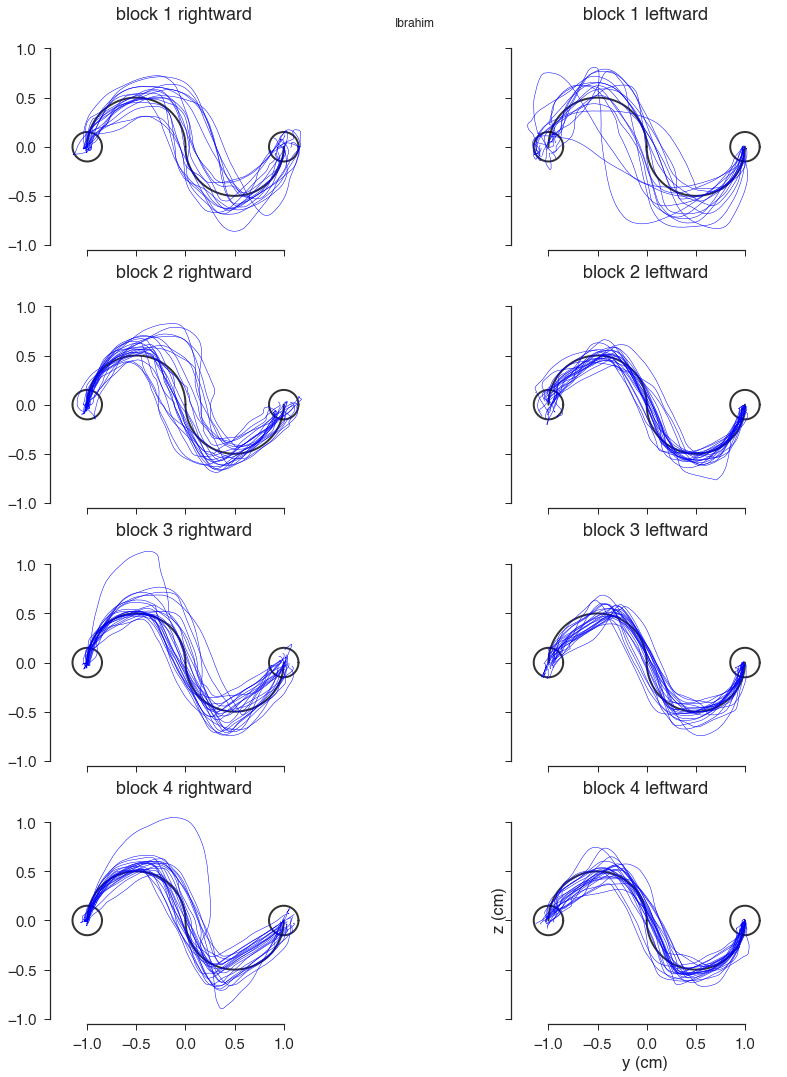

In [20]:
blocks = list(set(alltrials["block"]))
directions = list(set(alltrials["direction"]))

f,axs = subplots(len(blocks),len(directions),figsize=(15,15),sharex=True,sharey=True)
for i,bl in enumerate(blocks):
    for j,dr in enumerate(directions):
        axs[i][j].set_aspect('equal')
        axs[i][j].set_title("block %i %s"%(bl,dr))
        draw_arc(axs[i][j])

for i,row in alltrials.iterrows():  
    tr = row["cumul.trial"]
    bl = row["block"]
    dr = row["direction"]
    ax = axs[blocks.index(bl)][directions.index(dr)]
    traj = alltrajectories[tr]
    if len(traj):
        x,y,z=zip(*traj)
        ax.plot(y[:],z[:],'-',lw=.5,color='blue')

    
xlabel("y (cm)")
ylabel("z (cm)")
tight_layout()
sns.despine(offset=5,trim=True)
suptitle(SUBJECT)
savefig(FIGDIR+'raw_block_direction.pdf')

# Look at individual trajectories (so we can discard really "off" ones)

**TODO**


# Compute distances from arc

In [21]:
def in_start_target(x,y):
    dleft  = sqrt(sum(pow(array([x,y])-array(params["LEFT_ARC_ORIGIN"]),2)))
    dright = sqrt(sum(pow(array([x,y])-array(params["RIGHT_ARC_ORIGIN"]),2)))
    return dleft<params["TARGET_RADIUS"] or dright<params["TARGET_RADIUS"]

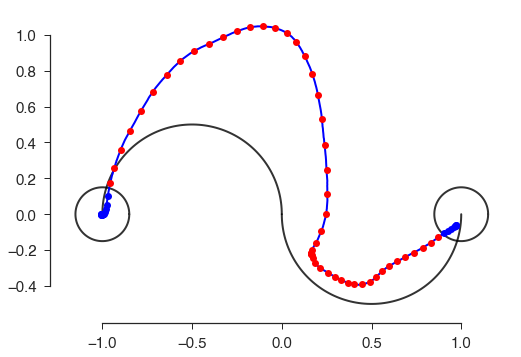

In [22]:
f,ax=subplots(1,1,figsize=(8,5))
draw_arc(ax)
tr = 151
traj = alltrajectories[tr]
x,y,z=zip(*traj)
ax.plot(y,z,'-',lw=2,color='blue')
for _,yi,zi in traj[::20]:
    ax.plot(yi,zi,'o',
            color='blue' if in_start_target(yi,zi) else 'red')
tight_layout()
sns.despine(offset=5,trim=True)

In [23]:
def distance_to_arc(x,y,cx,cy,rad,upper):
    """ 
    Distance to an arc of a given radius around a given center point.
    If upper=True, then the arc is the "upper" half of the circle, that is it extends to HIGHER y than cy
    If upper=False, then the arc is the "lower" half of the circle, that is, it extends to LOWER y than cy
    """
    # First, check that we are in the good half of the circle
    goodhalf = (y>cy and upper) or (y<cy and not upper)
    
    if goodhalf:
        dfromcenter= sqrt((x-cx)**2+(y-cy)**2)
        return abs(dfromcenter-rad)

    # else...
    # In this case, the shortest distance to the arc is the shortest
    # distance to the edges of the arc
    dleftedge  = sqrt((x-(cx-rad))**2+(y-cy)**2)
    drightedge = sqrt((x-(cx+rad))**2+(y-cy)**2)
    return min([dleftedge,drightedge])

In [24]:
def dist_from_arc(x,y):
    """ Given a point x,y, compute the distance to the arc """
        
    # First, let's see if we are in the starting zone or target zone
    if in_start_target(x,y): return 0.
    
    dleft  = distance_to_arc(x,y,params["ARC_BASE_X"]+params["ARC_RADIUS_2"],params["ARC_BASE_Y"],params["ARC_RADIUS_2"],upper=False)
    dright = distance_to_arc(x,y,params["ARC_BASE_X"]-params["ARC_RADIUS_1"],params["ARC_BASE_Y"],params["ARC_RADIUS_1"],upper=True)
    return min([dleft,dright])

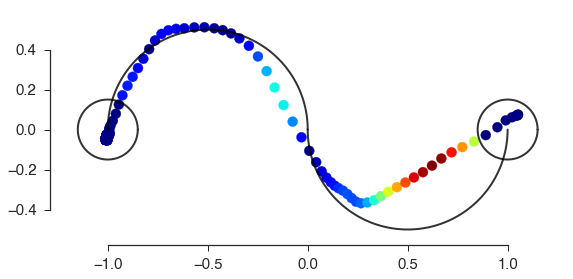

In [25]:
f,ax=subplots(1,1,figsize=(8,5))
draw_arc(ax)
tr = 153
traj = alltrajectories[tr]
x,y,z=zip(*traj)
#ax.plot(y,z,'-',lw=2,color='blue')
ds = [ (dist_from_arc(yi,zi),yi,zi) for _,yi,zi in traj[::20] ]
dz,yz,zz = zip(*ds)
plt.scatter(yz,zz,c=dz,s=100,cmap='jet')
tight_layout()
sns.despine(offset=5,trim=True)

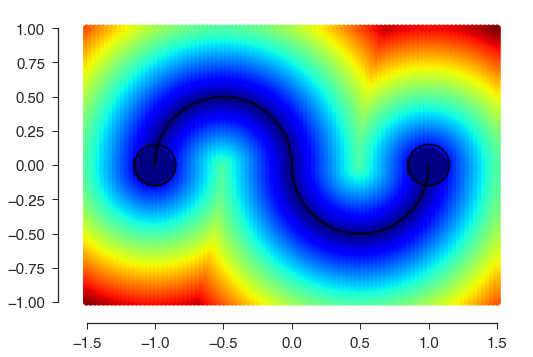

In [26]:
f,ax=subplots(1,1,figsize=(8,5))
draw_arc(ax)
#ax.plot(y,z,'-',lw=2,color='blue')
ds = [ (dist_from_arc(yi,zi),yi,zi) 
      for yi in linspace(-1.5,1.5,100)
      for zi in linspace(-1,1,100) ]
dz,yz,zz = zip(*ds)
plt.scatter(yz,zz,c=dz,s=50,cmap='jet')
#for _,yi,zi in traj[::20]:
#    d = dist_from_arc(yi,zi)
#    ax.plot(yi,zi,'o',color=(d*4,0,0),mec='black',mew=1,markersize=10)
tight_layout()
sns.despine(offset=5,trim=True)

In [27]:
t0=time.time()
computed = []
for i,row in alltrials.iterrows():  
    tr = row["cumul.trial"]
    traj = alltrajectories[tr]
    if len(traj):
        ds = [ dist_from_arc(yi,zi) for _,yi,zi in traj ]
        
        computed.append({"cumul.trial":tr,
                         "min.dist":min(ds),
                         "max.dist":max(ds),
                         "mean.dist":mean(ds),
                        "median.dist":median(ds)})

computed = pd.DataFrame(computed)
print("Phew, this took %f sec"%(time.time()-t0))

Phew, this took 8.162405 sec


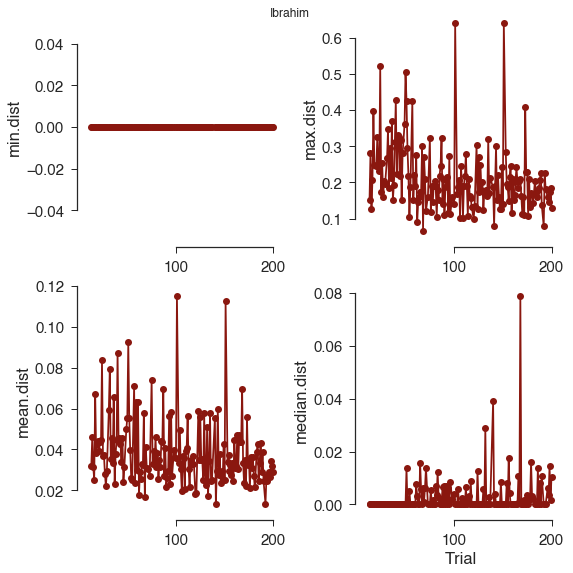

In [28]:
n,m=2,2
f,axs = subplots(n,m,figsize=(8,8))

for i,quant in enumerate(["min.dist","max.dist","mean.dist","median.dist"]):
    ax = subplot(n,m,i+1)
    ax.plot(computed["cumul.trial"],computed[quant],'o-')
    ax.set_ylabel(quant)
xlabel("Trial")
#ylabel("Max distance from arc (cm)")
tight_layout()
sns.despine(offset=5,trim=True)
suptitle(SUBJECT)
savefig(FIGDIR+'distances_from_arc.pdf')

# Compute velocity, smoothness?

**TODO**

# Output to something else

In [29]:
PICKLE_F = 'interim/allsubjects.pickle'
if os.path.exists(PICKLE_F):
    allsubj = pickle.load(open(PICKLE_F,'rb'))
else:
    allsubj = {}
    
allsubj[SUBJECT]=pd.merge(alltrials,computed,how='left')

pickle.dump(allsubj,open(PICKLE_F,'wb'))

In [30]:
combined = pd.concat(allsubj.values())
combined.to_csv('interim/allsubjects.csv')